In [4]:
import os
import pandas as pd
import re
from tqdm import tqdm
from utils import load_jsonl_iteratively

iter_losses = []
lang = "ja"
task_names = {
    'ja_knowledge_memorization': 'Memorization',
    'ja_knowledge_generalization': 'Intralingual',
    'en_knowledge_memorization': 'Interlingual',
    # 'en_knowledge_generalization': 'AdaXEval-En (gen)'
}
    
# ROOT = "/model/projects/cpt-scidoc/roman-pretrain/exp1-en_jstage"
if lang == "ja":
    ROOT = "/data/xzhao/experiments/roman-pretrain/exps/exp1-multi-ja/hf_models"
else:
    ROOT = "/data/xzhao/experiments/roman-pretrain/exps/exp1-multi-en_jstage/hf_models"

In [7]:

examples = {}
for fn in tqdm(os.listdir(ROOT)):
    if not fn.startswith("iter_"):
        continue

    iter_info = {task: [] for task in task_names}
    num_iter = int(re.match("iter_(\d+)", fn).group(1))
    if num_iter > 0 and num_iter < 1000:
        continue
    fn = os.path.join(ROOT, fn, "result.json")
    
    if not os.path.exists(fn):
        continue
    
    task2sample_ids = {task: set() for task in task_names}
    for item in load_jsonl_iteratively(fn):
        sample = item['sample']
        if 'dataset' not in sample:
            continue
        task = sample['dataset']
        if task not in task_names:
            continue
        
        sample_id = sample['sample_id']
        if sample_id in task2sample_ids[task]:
            continue
        
        task2sample_ids[task].add(sample_id)

        answer_idx = int(sample['answer_idx'])
        valid_loss = item['losses'][answer_idx]
        valid_normloss = item['norm_losses'][answer_idx]
        invalid_loss = sum([item['losses'][i] for i in range(4) if i != answer_idx])/3
        invalid_normloss = sum([item['norm_losses'][i] for i in range(4) if i != answer_idx])/3

        iter_info[task].append((sample_id, valid_loss, valid_normloss, invalid_loss, invalid_normloss))

    # for task in task2sample_ids:
    #     print("Iter {}: Task {} has {} samples".format(num_iter, task_names[task], len(task2sample_ids[task])))
    
    for task, losses in iter_info.items():
        sample_id, valid_loss, valid_normloss, invalid_loss, invalid_normloss = list(zip(*losses))

        iter_losses.append({
            'sample_id': sample_id,
            'num_iter': num_iter,
            'task': task_names[task],
            'valid_loss': sum(valid_loss)/len(valid_loss),
            'valid_normloss': sum(valid_normloss)/len(valid_normloss),
            'invalid_loss': sum(invalid_loss)/len(invalid_loss),
            'invalid_normloss': sum(invalid_normloss)/len(invalid_normloss),
            'valid_loss_ratio': sum(valid_loss) / (sum(valid_loss) + 3 * sum(invalid_loss)),
            'valid_normloss_ratio': sum(valid_normloss) / (sum(valid_normloss) + 3 * sum(invalid_normloss)),
            'num_sample': len(losses),
        })
df = pd.DataFrame(iter_losses)
    

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


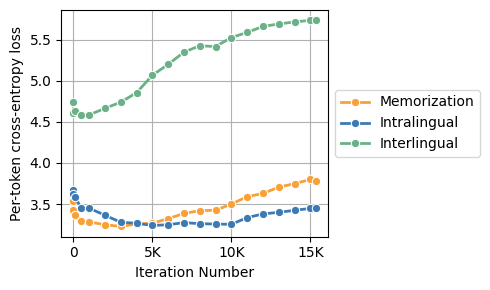

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


plt.figure(figsize=(5, 3))
sns.lineplot(
    data=df, x='num_iter', y='valid_normloss', 
    hue='task', linewidth=2, marker="o", 
    palette={'Memorization': '#F9A037', 'Intralingual': '#3D7AB3', 'Interlingual': '#6AB187'})
plt.xlabel("Iteration Number")
# plt.xscale('log')
plt.ylabel("Per-token cross-entropy loss")
plt.grid(True)

def thousands_formatter(x, pos):
    if x == 0: return '0'
    else:
        return f'{int(x / 1000)}K'
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.show()

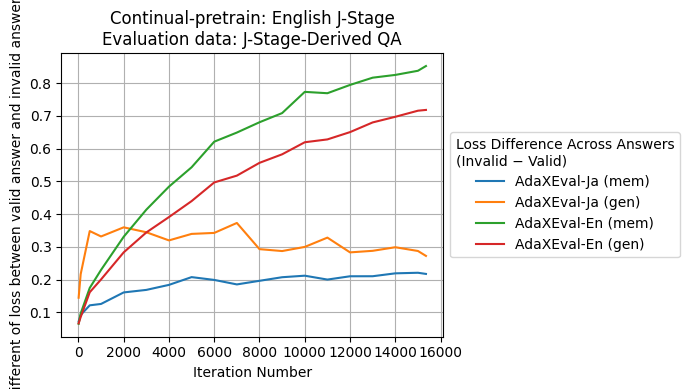

In [36]:
df['loss_diff'] = df['invalid_normloss'] - df['valid_normloss']
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df, 
    x='num_iter', 
    y='loss_diff', 
    hue='task')
plt.xlabel("Iteration Number")
# plt.xscale('log')
plt.ylabel("Different of loss between valid answer and invalid answers")
plt.grid(True)
plt.title('Continual-pretrain: English J-Stage\nEvaluation data: J-Stage-Derived QA')
plt.legend(
    title = "Loss Difference Across Answers\n(Invalid − Valid)",
    loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.show()

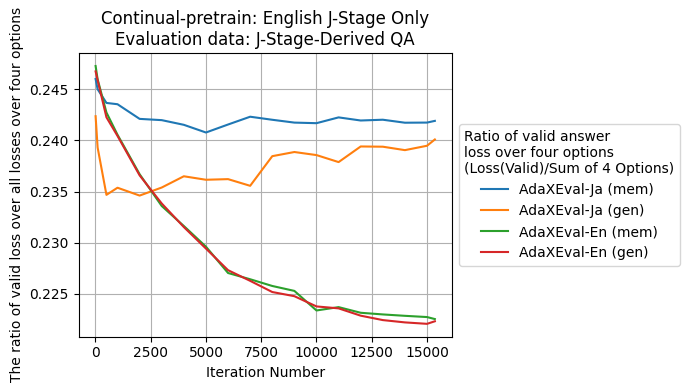

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [ ]:
plt.figure(figsize=(7, 4))
sns.lineplot(
    data=df, 
    x='num_iter', 
    y='valid_normloss_ratio', 
    hue='task')
plt.xlabel("Iteration Number")
# plt.xscale('log')
plt.ylabel("The ratio of valid loss over all losses over four options")
plt.grid(True)
plt.title('Continual-pretrain: English J-Stage Only\nEvaluation data: J-Stage-Derived QA')
plt.legend(
    title = "Ratio of valid answer \nloss over four options \n(Loss(Valid)/Sum of 4 Options)",
    loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.show()

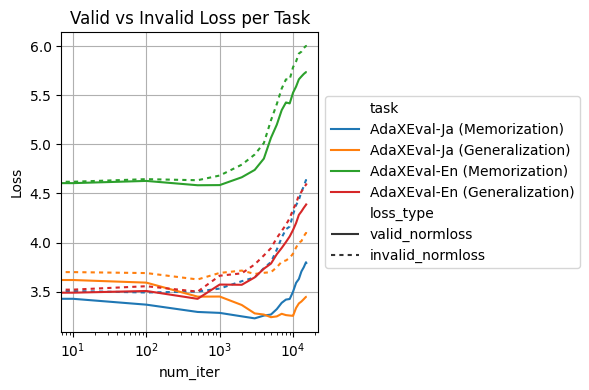

In [30]:
df_long = df.melt(
    id_vars=['num_iter', 'task'],
    value_vars=['valid_normloss', 'invalid_normloss'],
    var_name='loss_type',
    value_name='loss'
)

# Map loss_type to line style
line_styles = {'valid_normloss': (1, 0), 'invalid_normloss': (2, 2)}


# Plot
plt.figure(figsize=(6, 4))
sns.lineplot(
    data=df_long,
    x='num_iter',
    y='loss',
    hue='task',
    style='loss_type',
    dashes=line_styles
)

plt.title('Valid vs Invalid Loss per Task')
plt.xlabel('num_iter')
plt.ylabel('Loss')
plt.xscale('log')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


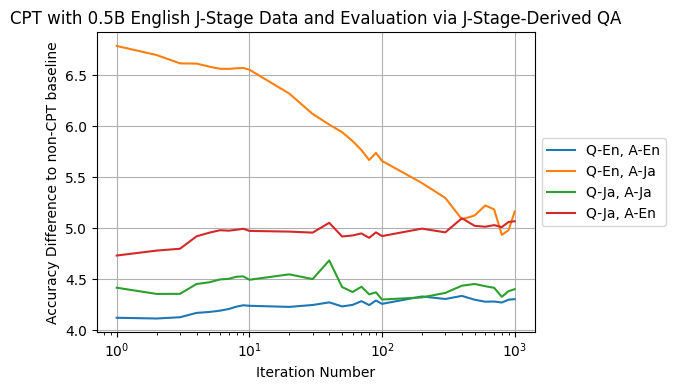

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5, 4))
sns.lineplot(
    data=df, 
    x='num_iter', 
    y='invalid_normloss', 
    hue='task')
plt.xlabel("Iteration Number")
plt.xscale('log')
plt.ylabel("Accuracy Difference to non-CPT baseline")
plt.grid(True)
plt.title('CPT with 0.5B English J-Stage Data and Evaluation via J-Stage-Derived QA')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.show()

In [61]:
examples

{'nii_ja5_mono_prompt-en': {'sample_id': 'sccj1979@@42/2/42_2_121',
  'question': 'After the addition of mental stress, the concentration of cortisol became which of the following?',
  'options': ['higher', 'lower', 'unchanged', 'stable'],
  'answer_idx': 0,
  'n_options': 4,
  'metadata': None,
  'dataset': 'nii_ja5_mono_prompt-en'},
 'nii_ja5_mono_prompt-ja': {'sample_id': 'sccj1979@@42/2/42_2_121',
  'question': '精神的ストレスを負荷した後、コルチゾールの濃度は次のうちどのようになりますか？',
  'options': ['高くなった', '低くなった', '変わらなかった', '安定した'],
  'answer_idx': 0,
  'n_options': 4,
  'metadata': None,
  'dataset': 'nii_ja5_mono_prompt-ja'},
 'nii_ja5_mono_prompt-en.cross': {'sample_id': 'sccj1979@@42/2/42_2_121',
  'question': 'After the addition of mental stress, the concentration of cortisol became which of the following?',
  'options': ['高くなった', '低くなった', '変わらなかった', '安定した'],
  'answer_idx': 0,
  'n_options': 4,
  'metadata': None,
  'dataset': 'nii_ja5_mono_prompt-en.cross'},
 'nii_ja5_mono_prompt-ja.cross': {'sample_id'